In [2]:
import numpy as np
import mne
from mne.datasets import sample
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal
from mne import channels, evoked, create_info
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import scipy.signal as sl
from typing import Optional
import scipy as sp
import sys
from nilearn import plotting
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.experimental.models import SPIRIT
from deepmeg.data.datasets import EpochsDataset, read_epochs_dataset
from torch.utils.data import DataLoader
from deepmeg.preprocessing.transforms import zscore
import torch
from collections import defaultdict
import torchmetrics
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg, PrintingCallback
from deepmeg.experimental.interpreters import SPIRITInterpreter
import random
import torch.nn as nn


def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [3]:
from deepmeg.models import BaseModel
import torch.nn as nn


def heaviside(x, k=20):
    return 1/(1e-7 + 1 + torch.exp(-2*k*x))

class LW(nn.Module):
    def __init__(self, n_times):
        super().__init__()
        self.n_times = n_times
        self.w1 = nn.Parameter(torch.empty(1, self.n_times))
        self.w2 = nn.Parameter(torch.empty(1, self.n_times))
        self.b = nn.Parameter(torch.empty(1, self.n_times))
        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.uniform_(self.w1, -0.01, 0.01)
        nn.init.uniform_(self.w2, -0.01, 0.01)
        nn.init.uniform_(self.b, -0.01, 0.01)

    def forward(self, x):
        x1 = x*self.w1 + self.b
        x2 = nn.functional.sigmoid(x*self.w2)

        return x1*x2


class LFCNNW(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.n_latent = n_latent
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        self.temp_sel = nn.ModuleList([LW(n_times) for _ in range(self.n_latent)])
        final_out_features = (n_times//pool_factor)*n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        x = torch.stack([lw(x[:, branch_n, :]) for lw, branch_n in zip(self.temp_sel, range(self.n_latent))], -2)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

X = torch.rand((1, 64, 600))

LFCNNW(64, 600, 8, 50, 10, 8)(X)

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[-0.0449, -0.0029,  0.0405, -0.0272,  0.0283, -0.0327,  0.0335,  0.0231]],
       grad_fn=<AddmmBackward0>)

In [4]:
dataset = read_epochs_dataset('../data/simulated_n2.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [5]:
x, y = next(iter(DataLoader(test, len(test))))
y.shape

torch.Size([86, 2])

In [8]:
kwargs = dict(
    n_channels=x.shape[1],
    n_times=x.shape[-1],
    filter_size=50,
    n_latent=8,
    pool_factor=10,
    n_outputs=y.shape[-1]
)

In [9]:
LFCNNW(
    **kwargs
)(x).shape

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([86, 2])

In [10]:
# from mne.datasets import multimodal
# fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
data_path = sample.data_path()
subjects_dir = data_path / 'subjects'
subject = 'sample'
meg_path = data_path / 'MEG' / subject
fname_raw = meg_path / 'sample_audvis_raw.fif'

info = mne.io.read_raw_fif(fname_raw).resample(600).pick_types(meg='grad').info

In [12]:
from deepmeg.models.interpretable import LFCNN
# model = TSNet(**lfcnn_kwargs)

model = LFCNNW(
    **kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                # 'unmixing_layer.weight',
                'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [32]:
sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.7100   |    binary_accuracy_train:  0.4872   |    loss_val:  0.7096   |    binary_accuracy_val:  0.5000
  1%|          | 1/150 [00:00<01:15,  1.97it/s]

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1:  loss_train:  0.7098   |    binary_accuracy_train:  0.4872   |    loss_val:  0.7096   |    binary_accuracy_val:  0.5000
Epoch 2:  loss_train:  0.7097   |    binary_accuracy_train:  0.4872   |    loss_val:  0.7095   |    binary_accuracy_val:  0.5000
Epoch 3:  loss_train:  0.7095   |    binary_accuracy_train:  0.4872   |    loss_val:  0.7094   |    binary_accuracy_val:  0.5217
Epoch 4:  loss_train:  0.7093   |    binary_accuracy_train:  0.5449   |    loss_val:  0.7093   |    binary_accuracy_val:  0.5326
Epoch 5:  loss_train:  0.7092   |    binary_accuracy_train:  0.5865   |    loss_val:  0.7092   |    binary_accuracy_val:  0.5000
Epoch 6:  loss_train:  0.7090   |    binary_accuracy_train:  0.5128   |    loss_val:  0.7091   |    binary_accuracy_val:  0.5000
Epoch 7:  loss_train:  0.7087   |    binary_accuracy_train:  0.5128   |    loss_val:  0.7089   |    binary_accuracy_val:  0.5000
Epoch 8:  loss_train:  0.7084   |    binary_accuracy_train:  0.5128   |    loss_val:  0.7087   | 

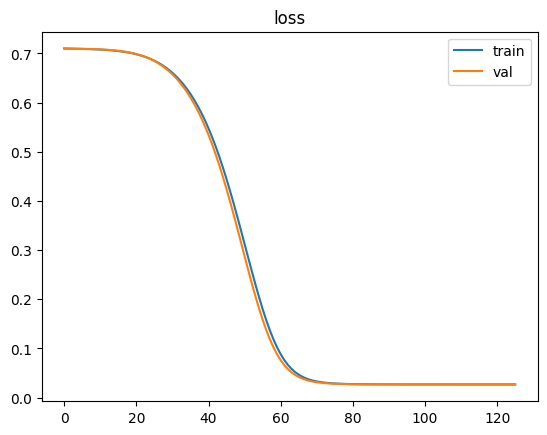

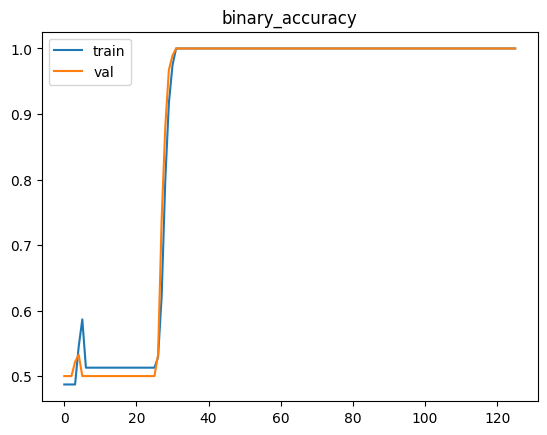

In [13]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [14]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.02658219076693058
train_binary_accuracy: 1.0
loss: 0.026727826249870388
binary_accuracy: 1.0


In [87]:
dataset = read_epochs_dataset('../data/multimodal.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [88]:
from mne.datasets import multimodal
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')

info = mne.io.read_raw_fif(fname_raw).pick_types(meg='grad').info

In [89]:
x, y = next(iter(DataLoader(train, 2)))
x.shape, y.shape

(torch.Size([2, 204, 301]), torch.Size([2, 8]))

In [86]:
sys.stdout = sys.stdout.file

In [18]:
from deepmeg.training.callbacks import Callback
from deepmeg.training.trainers import Trainer

class WeightClipper(object):
    def __init__(self, model):
        self.model = model

    def __call__(self, module):
        self.model.temp_conv.weight -= self.model.temp_conv.weight.mean(-1, keepdim=True)

class TempWeightsZeroMean(Callback):
    def __init__(self):
        super().__init__()

    def set_trainer(self, trainer: Trainer):
        super().set_trainer(trainer)
        self.model = self.trainer.model
        self.clipper = WeightClipper(self.model)

    @torch.no_grad()
    def on_batch_end(
        self,
        Y: torch.Tensor,
        Y_pred: torch.Tensor,
        metrics: dict
    ):
        self.model.apply(self.clipper)

In [21]:
from deepmeg.models.interpretable import LFCNN
from deepmeg.models.experimental import FourierSPIRIT

# model = TSNet(**lfcnn_kwargs)

model = LFCNNW(
    n_channels=x.shape[1],
    n_times=x.shape[-1],
    filter_size=50,
    n_latent=8,
    pool_factor=10,
    n_outputs=y.shape[-1]
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        TempWeightsZeroMean(),
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight',
                'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [22]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

Epoch 0:  loss_train:  0.7259   |    binary_accuracy_train:  0.3548   |    loss_val:  0.7235   |    binary_accuracy_val:  0.4891
  1%|          | 1/150 [00:00<01:16,  1.94it/s]

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1:  loss_train:  0.7239   |    binary_accuracy_train:  0.4919   |    loss_val:  0.7217   |    binary_accuracy_val:  0.7500
Epoch 2:  loss_train:  0.7221   |    binary_accuracy_train:  0.7500   |    loss_val:  0.7199   |    binary_accuracy_val:  0.7500
Epoch 3:  loss_train:  0.7203   |    binary_accuracy_train:  0.7500   |    loss_val:  0.7181   |    binary_accuracy_val:  0.7500
Epoch 4:  loss_train:  0.7184   |    binary_accuracy_train:  0.7500   |    loss_val:  0.7162   |    binary_accuracy_val:  0.7500
Epoch 5:  loss_train:  0.7164   |    binary_accuracy_train:  0.7500   |    loss_val:  0.7142   |    binary_accuracy_val:  0.7500
Epoch 6:  loss_train:  0.7143   |    binary_accuracy_train:  0.7500   |    loss_val:  0.7121   |    binary_accuracy_val:  0.7500
Epoch 7:  loss_train:  0.7121   |    binary_accuracy_train:  0.7500   |    loss_val:  0.7098   |    binary_accuracy_val:  0.7500
Epoch 8:  loss_train:  0.7098   |    binary_accuracy_train:  0.7500   |    loss_val:  0.7074   | 

In [23]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.08271676911549135
train_binary_accuracy: 1.0
loss: 0.09133952314203436
binary_accuracy: 0.9943181818181818


In [22]:
from deepmeg.experimental.interpreters import SPIRITInterpreter
import matplotlib
from copy import deepcopy
from deepmeg.utils.colors import generate_cmap

class LFCNNWInterpreter(SPIRITInterpreter):
    @torch.no_grad()
    def compute_temporal(self):
        loader = DataLoader(self.dataset, len(self.dataset))
        n_latent = self.model.unmixing_layer.weight.shape[0]
        x, y = next(iter(loader))

        x = self.model.unmixing_layer(x)
        x = self.model.temp_conv(x)
        # latent_sources_weighted = [lw(x[:, branch_n, :]) for lw, branch_n in zip(self.temp_sel, range(self.n_latent))]
        temporal_patterns, latent_sources_weighted = list(), list()
        for i, lw in enumerate(self.model.temp_sel):
            source = x[:, i, :]
            x1 = source*lw.w1 + lw.b
            x2 = nn.functional.sigmoid(source*lw.w2)
            temporal_patterns.append(x2[:, ::self.model.pool_factor].contiguous())
            latent_sources_weighted.append(x1*x2)
        return torch.stack(temporal_patterns, -2).numpy(), torch.stack(latent_sources_weighted, -2).numpy()

    def plot_branch(
        self,
        branch_num: int,
        spec_plot_elems: list[str] = ['input', 'output', 'response'],
        title: str = None
    ) -> matplotlib.figure.Figure:

        info = deepcopy(self.info)
        info.__setstate__(dict(_unlocked=True))
        info['sfreq'] = 1.
        order = np.argsort(self.branchwise_loss)
        patterns_sorted = self.spatial_patterns[:, order]
        latent_sources_sorted = self.latent_sources[:, order, :]
        latent_sources_filt_sorted = self.latent_sources_filtered[:, order, :]
        latent_sources_weight_sorted = self.latent_sources_weighted[:, order, :]
        temporal_patterns_sorted = self.temporal_patterns[:, order, :]
        fake_evo = mne.evoked.EvokedArray(np.expand_dims(patterns_sorted[:, branch_num], 1), info, tmin=0)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        times = np.arange(0, latent_sources_sorted.shape[-1]/self.info['sfreq'], 1/self.info['sfreq'])
        ax2.plot(
            times,
            sp.stats.zscore(latent_sources_sorted.mean(0)[branch_num]),
            linewidth=2, alpha=.25
        )
        ax2.plot(
            times,
            sp.stats.zscore(latent_sources_filt_sorted.mean(0)[branch_num]),
            color='tab:blue',
            linewidth=1
        )

        branch_tempwise_estimate = temporal_patterns_sorted.mean(0)[branch_num]
        interp_cubic = lambda y: sp.interpolate.interp1d(np.linspace(0, times[-1], len(y)), y, 'cubic')(times)

        ax2.plot(
            times,
            sp.stats.zscore(interp_cubic(branch_tempwise_estimate)),
            color='tab:red',
            linewidth=1.25,
            linestyle='--',
            alpha=.75
        )

        ax2.set_ylabel('Amplitude, zscore')
        ax2.set_xlabel('Time, s')
        ax2.legend(['spatially filtered', 'temporally filtered', 'temporal pattern'], loc='upper right')

        spec_legend = list()
        x = np.arange(0, self.frequency_range[-1], .1)

        interp_cubic = lambda y: sp.interpolate.interp1d(self.frequency_range, y, 'cubic')(x)

        plt.xlim(0, 100)
        if 'input' in spec_plot_elems:
            spec_legend.append('input')
            data = sp.stats.zscore(np.real(self.filter_inputs[order[branch_num]].mean(0)))
            data -= data.min()
            ax3.plot(
                x,
                sp.stats.zscore(
                    interp_cubic(data)
                ),
                color='tab:blue',
                alpha=.25
            )
        if 'output' in spec_plot_elems:
            spec_legend.append('output')
            data = sp.stats.zscore(np.real(self.filter_outputs[order[branch_num]].mean(0)))
            data -= data.min()
            ax3.plot(
                x,
                sp.stats.zscore(
                    interp_cubic(data)
                ),
                color='tab:blue',
                linewidth=.75
            )
        if 'response' in spec_plot_elems:
            spec_legend.append('response')
            data = sp.stats.zscore(np.real(self.filter_responses[order[branch_num]]))
            data -= data.min()
            ax3.plot(
                x,
                interp_cubic(data),
                color='tab:red',
                alpha=.75,
                linestyle='--'
            )
        if 'pattern' in spec_plot_elems:
            spec_legend.append('pattern')
            data = sp.stats.zscore(np.real(self.filter_patterns[order[branch_num]].mean(0)))
            data -= data.min()
            ax3.plot(
                x,
                sp.stats.zscore(
                    interp_cubic(data)
                ),
                color='tab:blue',
                alpha=.75,
                linestyle=':'
            )
        ax3.legend(spec_legend, loc='upper right')
        ax3.set_ylabel('Amplitude, zscore')
        ax3.set_xlabel('Frequency, Hz')
        ax3.set_xlim(0, 100)

        fake_evo.plot_topomap(
            times=0,
            axes=ax1,
            colorbar=False,
            scalings=1,
            time_format="",
            outlines='head',
            cmap=generate_cmap(
                '#1f77b4',
                '#ffffff',
                '#d62728'
            )
        )
        if title:
            fig.suptitle(f'Branch {branch_num}')

        fig.tight_layout()

        return fig


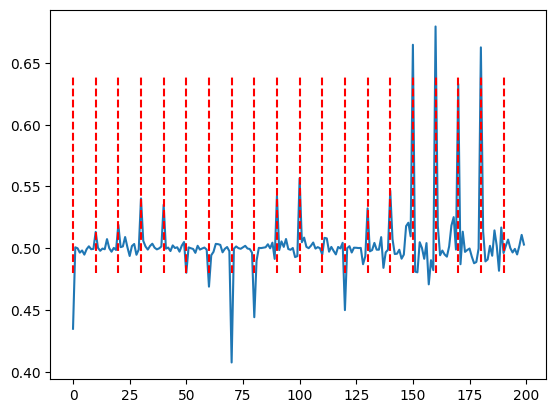

In [16]:
interpreter = LFCNNWInterpreter(model, test, info)
# plt.plot(interpreter.temporal_patterns.mean(0)[0][:200])
plt.plot(interpreter.temporal_patterns[0][0][:200])
plt.vlines(range(0, 200, 10), 0.48, 0.64, 'r', '--')

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


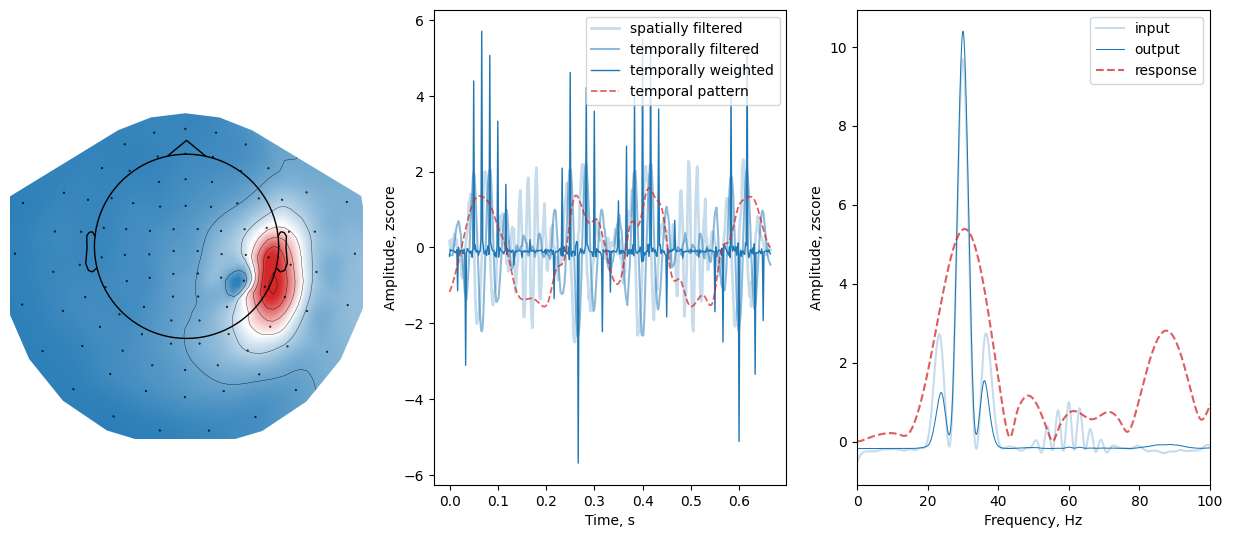

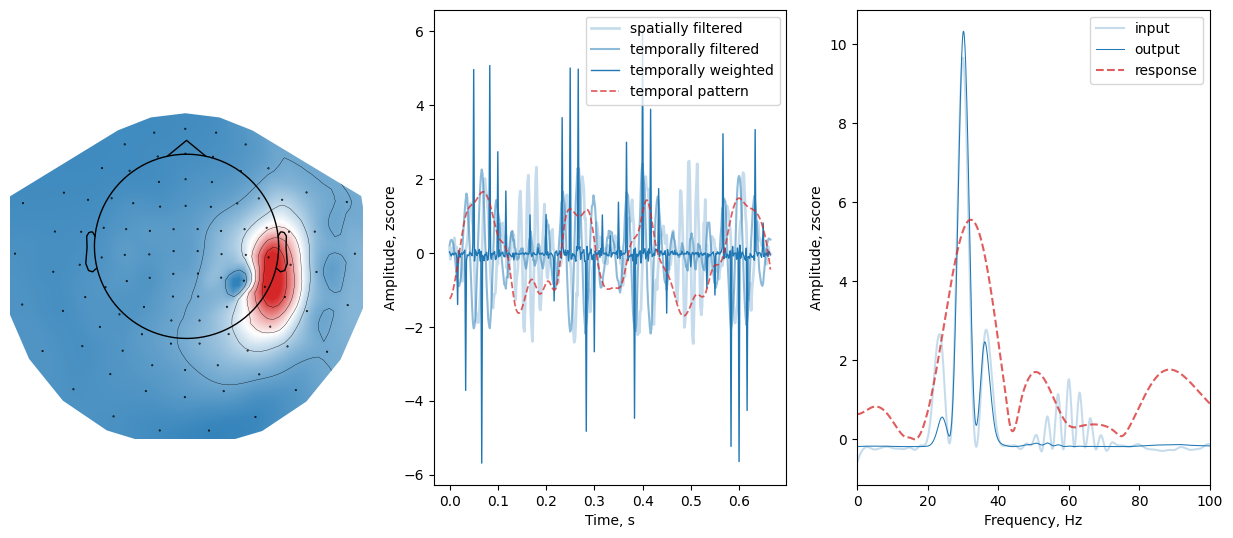

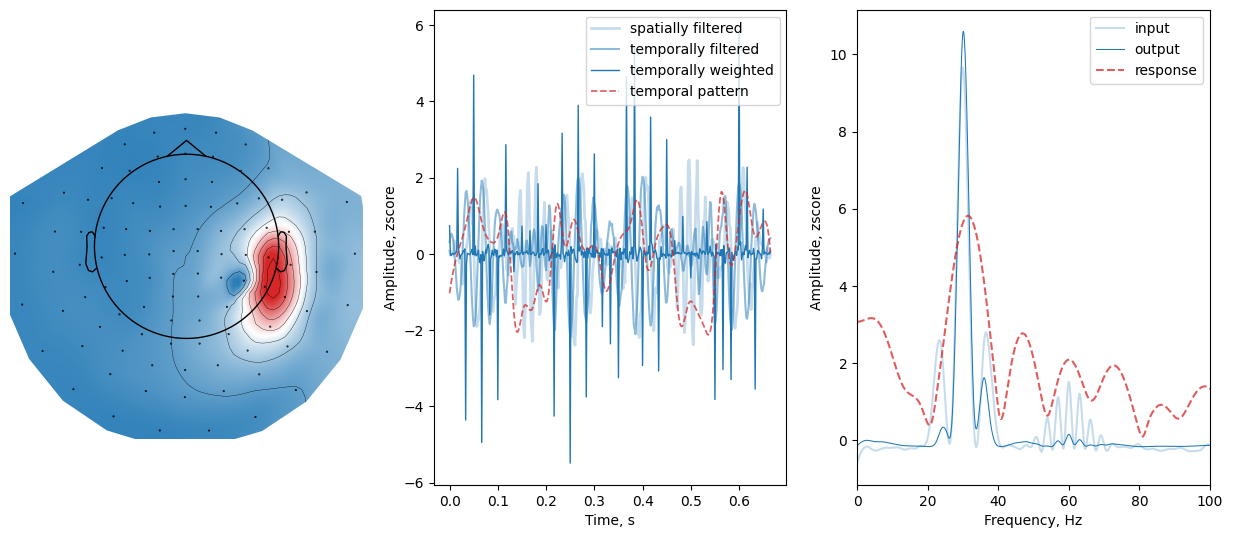

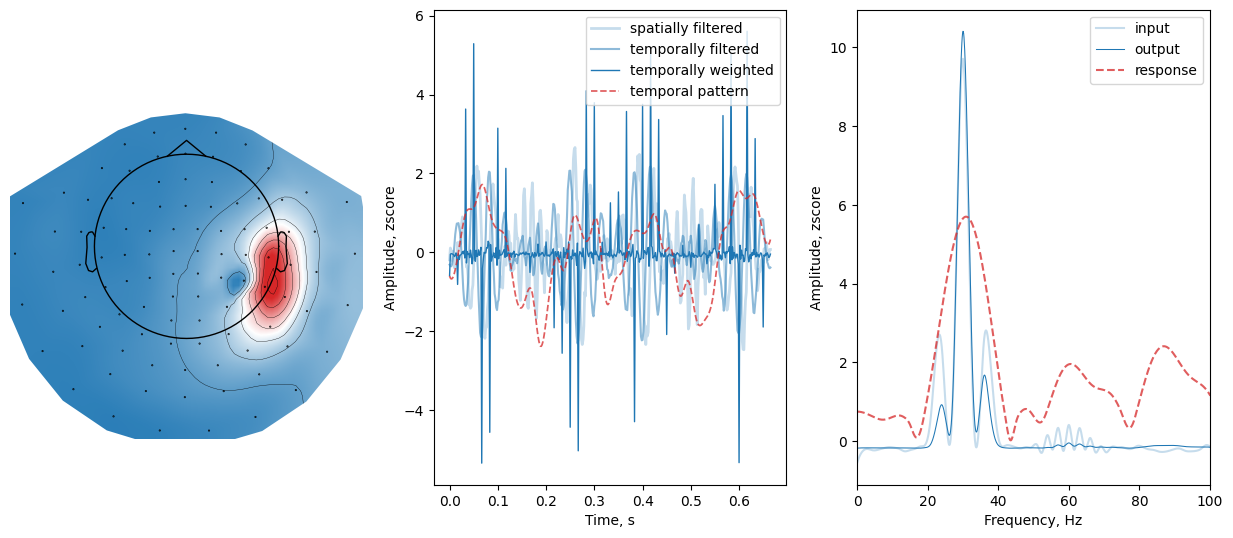

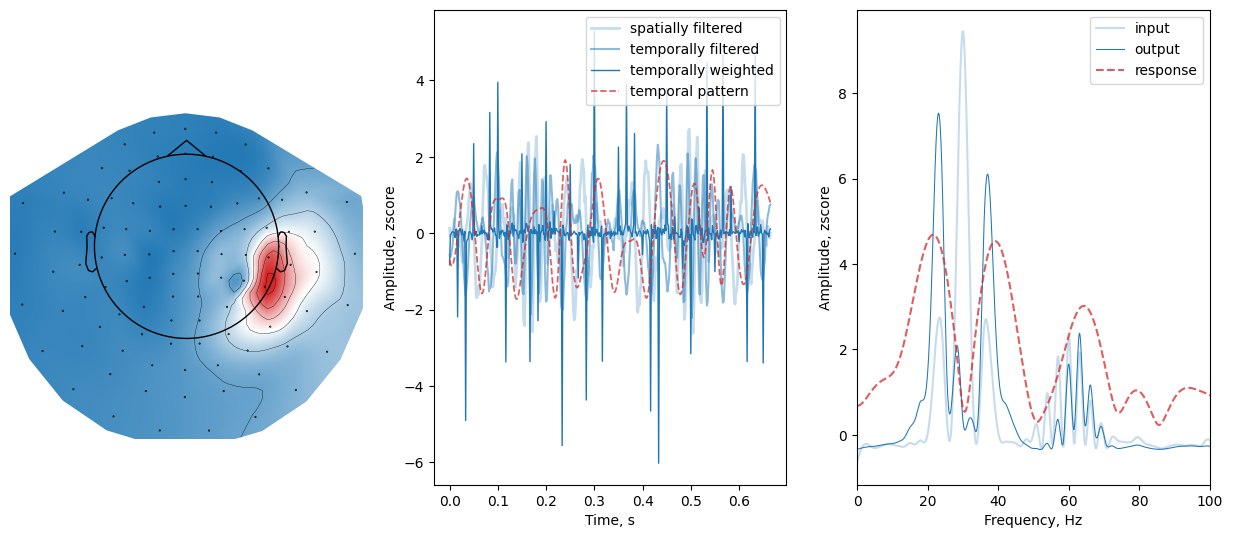

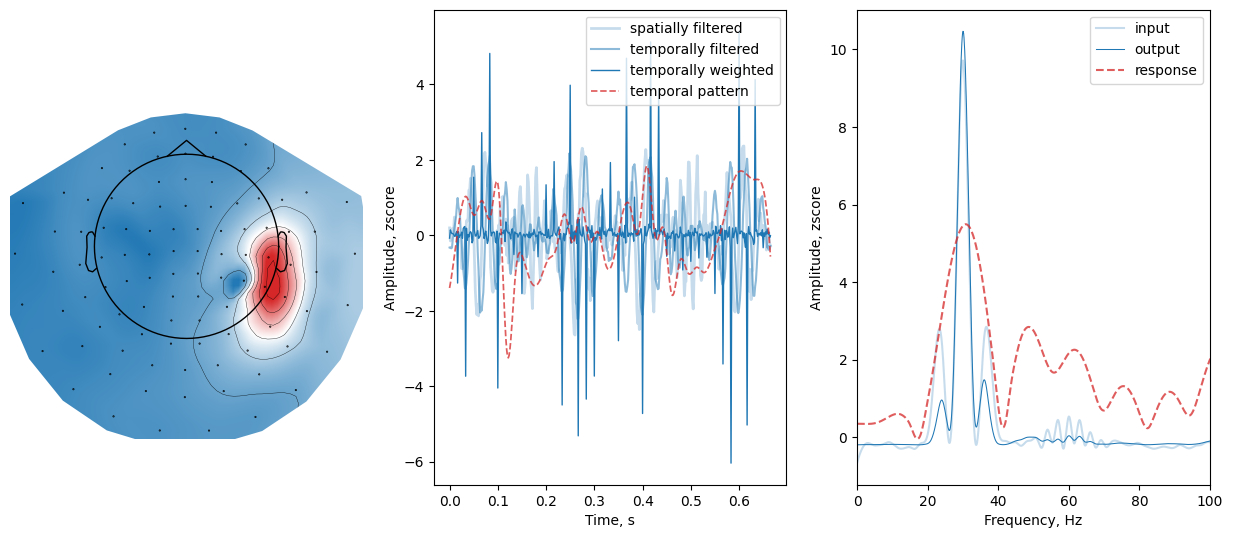

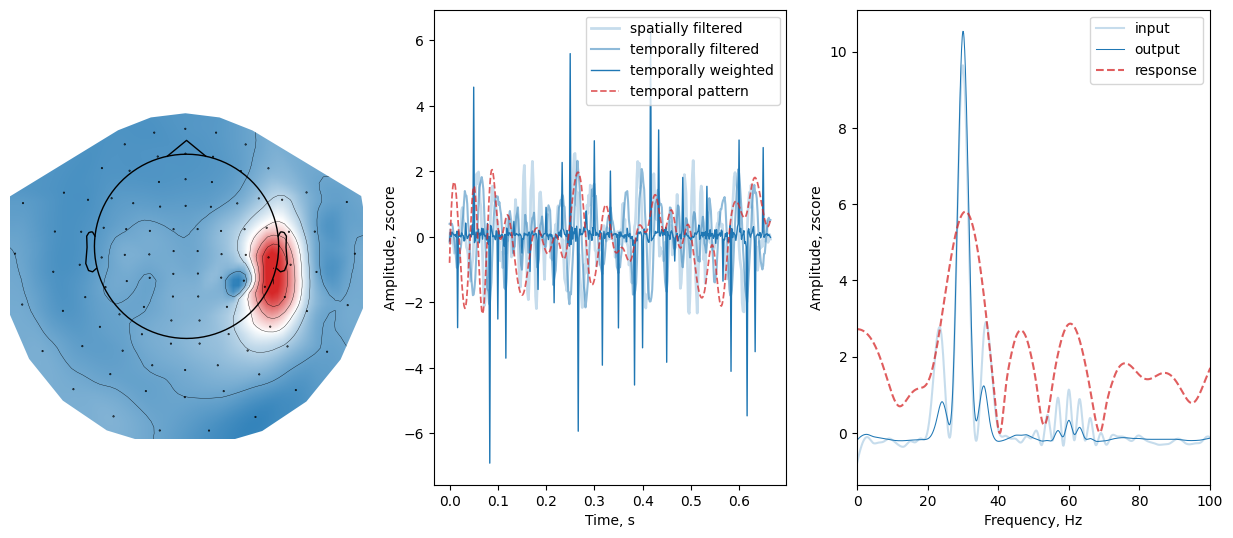

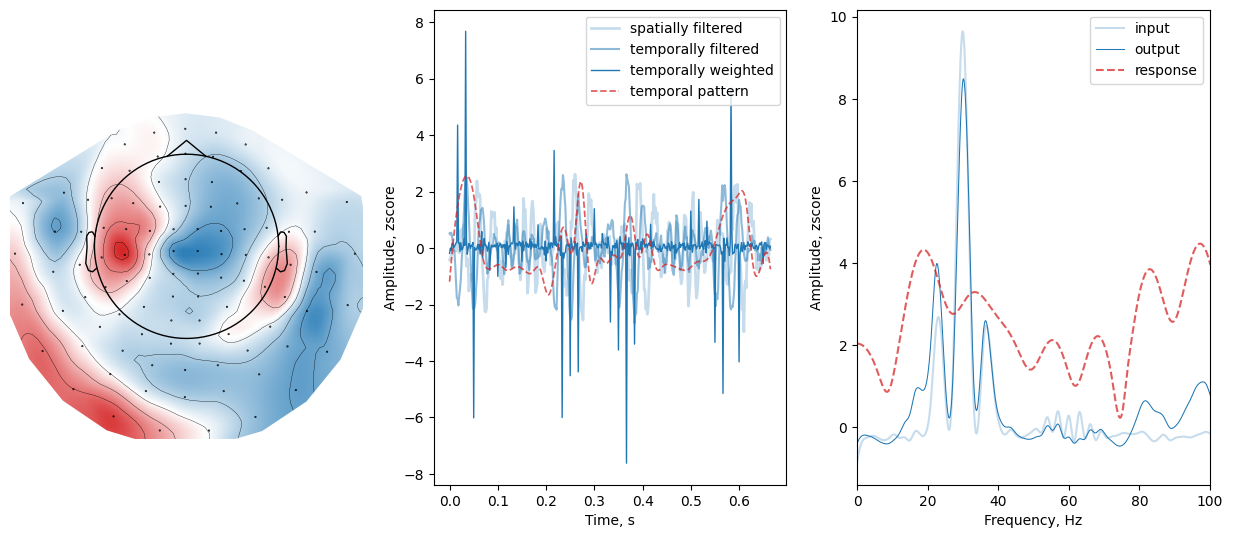

In [21]:
%matplotlib inline
interpreter = LFCNNWInterpreter(model, test, info)
# interpreter = SPIRITInterpreter(model, test, info)
for branch in range(8):
    fig = interpreter.plot_branch(branch)
    plt.show()

In [13]:
from deepmeg.utils.params import LFCNNParameters, SPIRITParameters

params = SPIRITParameters(interpreter)

QApplication: invalid style override 'kvantum' passed, ignoring it.
	Available styles: Windows, Fusion
/home/user/Projects/deepmeg/deepmeg/utils/viz.py:363: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if summarize == 'sum':
/home/user/Projects/deepmeg/deepmeg/utils/viz.py:365: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif summarize == 'sumabs':
/home/user/Projects/deepmeg/deepmeg/utils/viz.py:367: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif summarize == 'abssum':


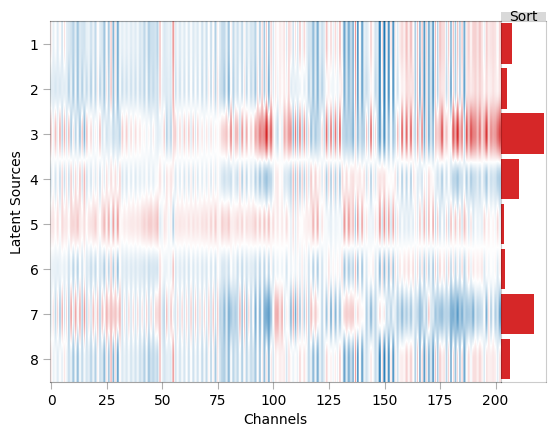

In [16]:
from deepmeg.utils.viz import InterpretationPlotter
%matplotlib qt

plotter = InterpretationPlotter(params, params.order)
plotter.plot()